In [1]:
#importing modules

import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.stattools import acf
from itertools import product
from dateutil.parser import parse
from dateutil import parser
import pandas as pd
import numpy as np
from sklearn import preprocessing
import time

In [2]:
!python --version

Python 3.7.3


In [3]:
#loading data
df_sales_train = pd.read_csv("sales_train.csv") 
df_items = pd.read_csv("items.csv") 
df_item_categories = pd.read_csv("item_categories.csv") 
df_shops = pd.read_csv("shops.csv")

# Inspecting data

In [4]:
#df_sales_train
print("***********-Top-5-***************")
print(df_sales_train.head(5)) 
print("**********Shape of Data**********")
print(df_sales_train.shape)
print("***********Data Types************")
print(df_sales_train.dtypes)
print("****Additional Information*******")
print(df_sales_train.info())
print("*********Missing values**********")
print(df_sales_train.isnull().sum())
print("*********Null values*************")
print(df_sales_train.isna().sum())

***********-Top-5-***************
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
**********Shape of Data**********
(2935849, 6)
***********Data Types************
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
****Additional Information*******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
it

# Checking for outliers

Item price outliers: [11365  6066 13199]


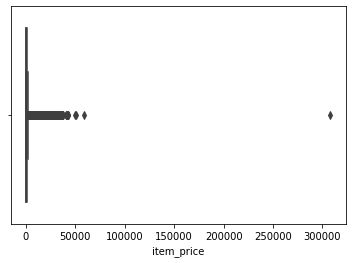

In [5]:
#we will use boxplots to detect outliers if any

#item_price
sns.boxplot(x=df_sales_train['item_price'])
print('Item price outliers:',df_sales_train['item_id'][df_sales_train['item_price']>50000].unique())

Item count day outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]


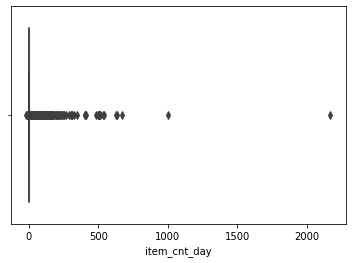

In [6]:
#item_cnt_day
sns.boxplot(x=df_sales_train['item_cnt_day'])
print('Item count day outliers:',df_sales_train['item_id'][df_sales_train['item_cnt_day']>500].unique())


# Sanity Check

In [7]:
#Checking if prices attribute has negative values
print('Number of tuples having negative price value:', len(df_sales_train[df_sales_train['item_price']<0]))
df_sales_train[df_sales_train['item_price']<0]


Number of tuples having negative price value: 1


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
df_sales_train = df_sales_train.drop(df_sales_train.index[df_sales_train['item_price']<0])

In [9]:
#Checking if count attribute has negative values
print('Number of tuples having negative count value:', len(df_sales_train[df_sales_train['item_cnt_day']<0]))

#We cannot drop so many values, hence we will replace them with the mean of all the values

Number of tuples having negative count value: 7356


In [10]:
#Merging all required dataframes

df_shops = pd.read_csv("shops.csv")
df_item_categories = pd.read_csv("item_categories.csv")
df_items = pd.read_csv("items.csv")
merged_inner = pd.merge(left=df_sales_train,right=df_shops, left_on='shop_id', right_on='shop_id')
merged_inner1 = pd.merge(left=merged_inner,right=df_items, left_on='item_id', right_on='item_id')
df_combined = pd.merge(left=merged_inner1,right=df_item_categories, left_on='item_category_id', right_on='item_category_id')


In [11]:
#Replace negative count by average count grouped by category id

df_combined[df_combined['item_cnt_day'] < 0] = np.nan
grouped = df_combined.groupby('item_category_id')['item_cnt_day'].mean().astype(int)
grouped.to_frame()
df_combined_mean = pd.merge(left=df_combined,right=grouped, left_on='item_category_id', right_on='item_category_id')
df_no_y = df_combined_mean.drop('item_cnt_day_y', axis=1)
df_final = df_no_y.rename(columns={'item_cnt_day_x': 'item_cnt_day'})
df_final.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0.0,59.0,22154.0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray
1,02.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray
2,03.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray
3,20.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray
4,23.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray


# Exploratory Data Analysis

In [12]:
#Extracting day,month and year

df_final.date_block_num.value_counts(dropna=False)
datesep = df_final["date"].str.split(".",expand=True)
df_final["Day"] = datesep[0]
df_final["Month"] = datesep[1]
df_final["Year"] = datesep[2]
df_final.head()

# df_combined_mean.name = 'df_combined_mean'
# df_combined_mean.csv_path = 'df_combined_mean.csv'
# df_combined_mean.to_csv(df_combined_mean.csv_path)


# df_combined_mean.groupby('Year')['shop_id'].nunique().plot(kind='bar')
# plt.show()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,Day,Month,Year
0,02.01.2013,0.0,59.0,22154.0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray,02,01,2013
1,02.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray,02,01,2013
2,03.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray,03,01,2013
3,20.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray,20,01,2013
4,23.01.2013,0.0,25.0,22154.0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37.0,Кино - Blu-Ray,23,01,2013


# Shop-wise sales trends

In [13]:
#Divide the dataframes year-wise and groupby shop-id
df_2013 = df_final[df_final["Year"] == "2013"]
df_2014 = df_final[df_final["Year"] == "2014"]
df_2015 = df_final[df_final["Year"] == "2015"]
grp_2013 = df_2013.groupby('shop_id').size().reset_index(name = 'ShopSaleByYear2013')
grp_2014 = df_2014.groupby('shop_id').size().reset_index(name = 'ShopSaleByYear2014')
grp_2015 = df_2015.groupby('shop_id').size().reset_index(name = 'ShopSaleByYear2015')


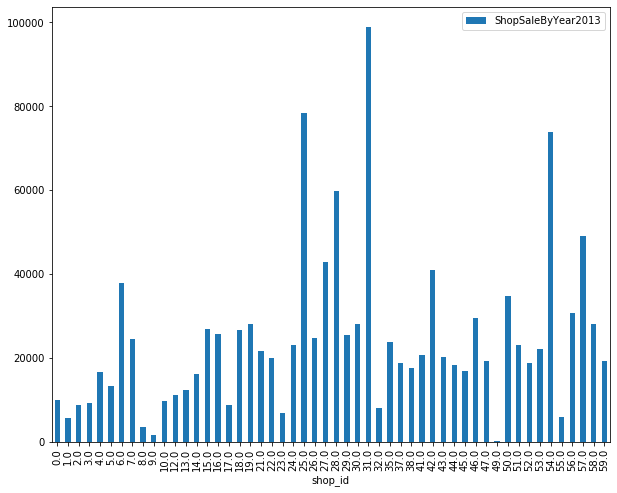

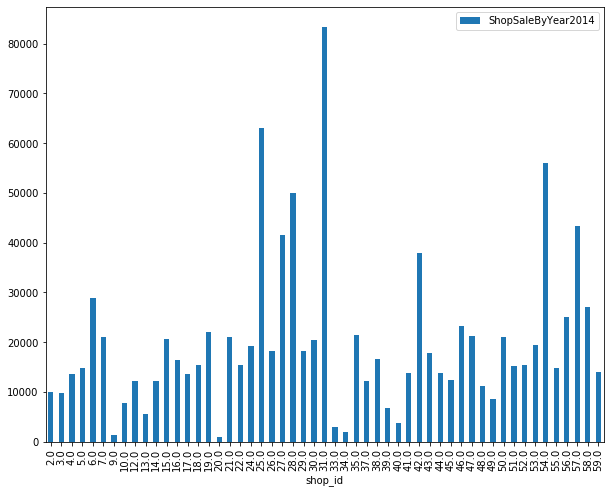

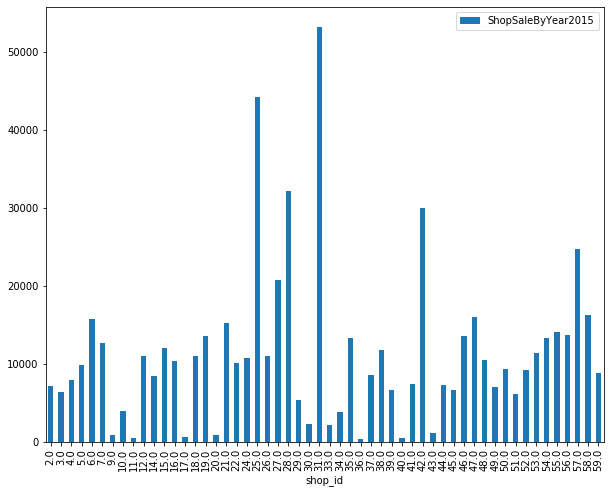

In [14]:
#Yearly performances of all shops

grp_2013.plot(kind='bar', x='shop_id', y='ShopSaleByYear2013',figsize = (10,8))
grp_2014.plot(kind='bar', x='shop_id', y='ShopSaleByYear2014',figsize = (10,8))
grp_2015.plot(kind='bar', x='shop_id', y='ShopSaleByYear2015',figsize = (10,8))

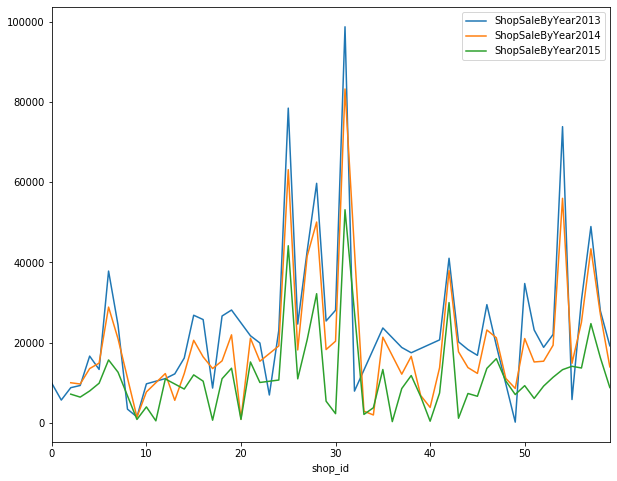

In [15]:
#Comparisons

ax = plt.gca()
grp_2013.plot(kind='line',x='shop_id',y='ShopSaleByYear2013', ax=ax,figsize = (10,8))
grp_2014.plot(kind='line',x='shop_id',y='ShopSaleByYear2014', ax=ax, figsize = (10,8))
grp_2015.plot(kind='line',x='shop_id',y='ShopSaleByYear2015', ax=ax, figsize = (10,8))

plt.show()


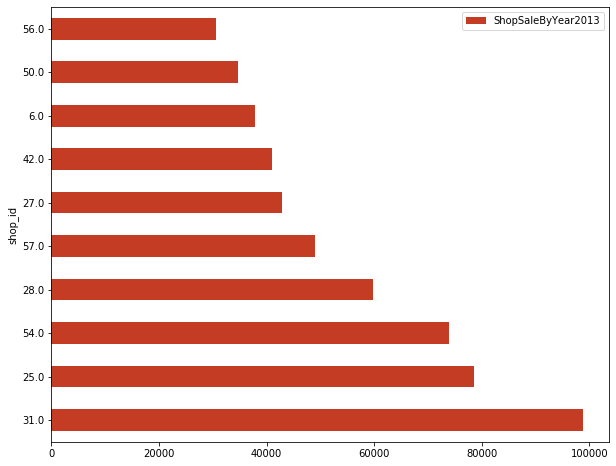

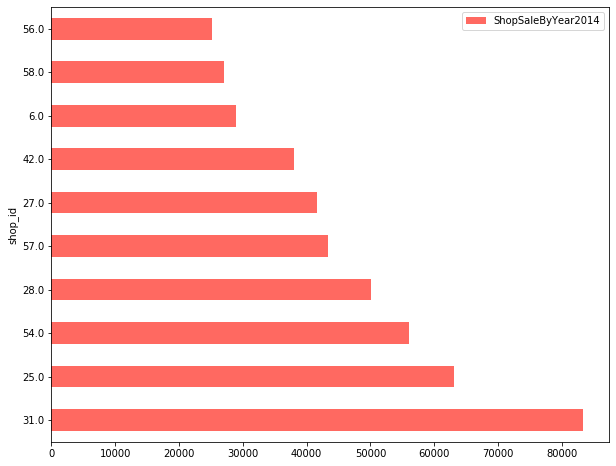

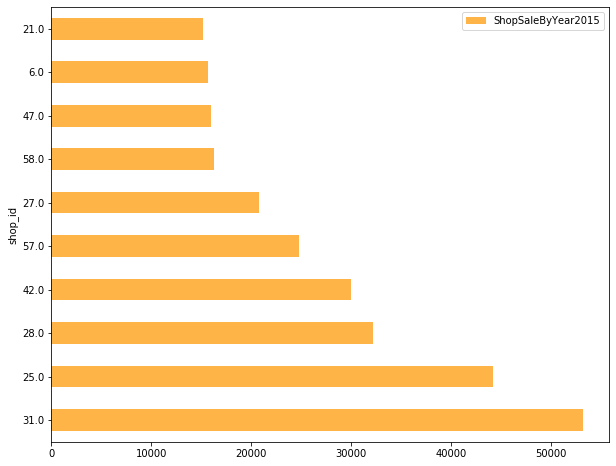

In [16]:
#Top 10 Shops year-wise
top_2013 = grp_2013.sort_values(by=['ShopSaleByYear2013'], ascending=False).head(10)
top_2014 = grp_2014.sort_values(by=['ShopSaleByYear2014'], ascending=False).head(10)
top_2015 = grp_2015.sort_values(by=['ShopSaleByYear2015'], ascending=False).head(10)

top_2013.plot(kind='barh', x='shop_id', y='ShopSaleByYear2013', color='#C33C23',figsize = (10,8))
top_2014.plot(kind='barh', x='shop_id', y='ShopSaleByYear2014', color='#FF6961',figsize = (10,8))
top_2015.plot(kind='barh', x='shop_id', y='ShopSaleByYear2015', color='#FFB447',figsize = (10,8))

# Item-wise sales trends

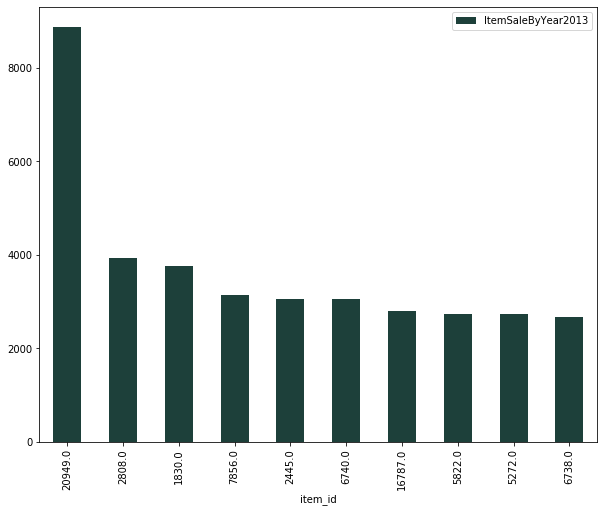

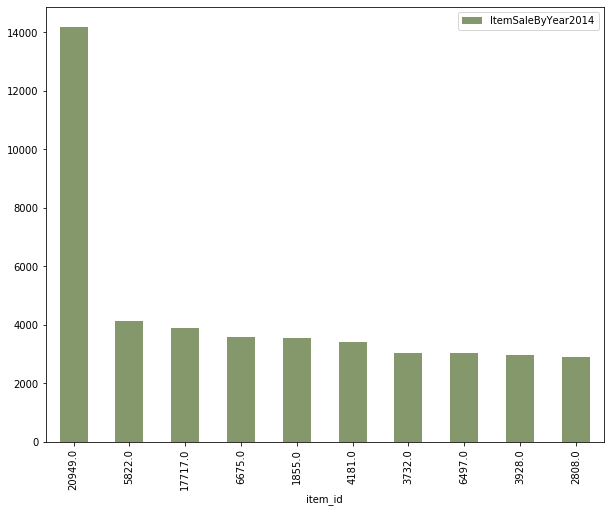

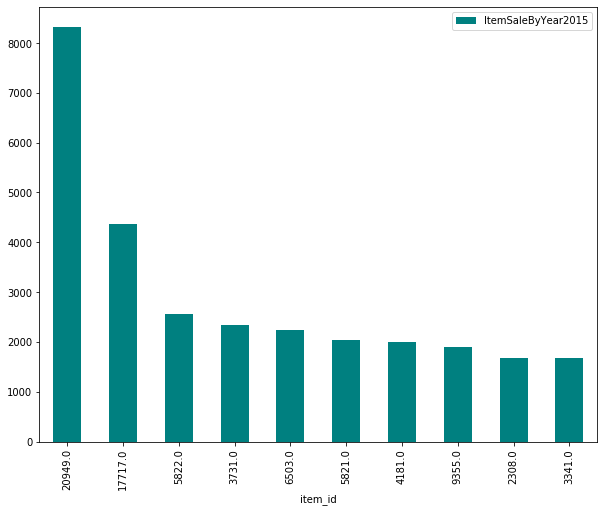

In [17]:
#Yearly trend 

item_2013 = df_2013.groupby('item_id').size().reset_index(name = 'ItemSaleByYear2013')
item_2014 = df_2014.groupby('item_id').size().reset_index(name = 'ItemSaleByYear2014')
item_2015 = df_2015.groupby('item_id').size().reset_index(name = 'ItemSaleByYear2015')

#Finding the top 10 items per year
topitem_2013 = item_2013.sort_values(by=['ItemSaleByYear2013'], ascending=False).head(10)
topitem_2014 = item_2014.sort_values(by=['ItemSaleByYear2014'], ascending=False).head(10)
topitem_2015 = item_2015.sort_values(by=['ItemSaleByYear2015'], ascending=False).head(10)



topitem_2013.plot(kind='bar', x='item_id', y='ItemSaleByYear2013',color='#1D403A',figsize = (10,8))
topitem_2014.plot(kind='bar', x='item_id', y='ItemSaleByYear2014',color='#84986B',figsize = (10,8))
topitem_2015.plot(kind='bar', x='item_id', y='ItemSaleByYear2015',color='#008080',figsize = (10,8))

In [18]:
#Month-wise sales for top 10 items

topitem5_2013 = item_2013.sort_values(by=['ItemSaleByYear2013'], ascending=False).head(5)
k = df_2013.groupby(['Month','item_id']).size().reset_index(name = 'bymonth')

seth = pd.merge(left=k,right=topitem5_2013, left_on='item_id', right_on='item_id')
seth.head()
#topitem_2013

,Month,item_id,bymonth,ItemSaleByYear2013
0,01,1830.0,416,3766
1,02,1830.0,451,3766
2,03,1830.0,408,3766
3,04,1830.0,266,3766
4,05,1830.0,249,3766


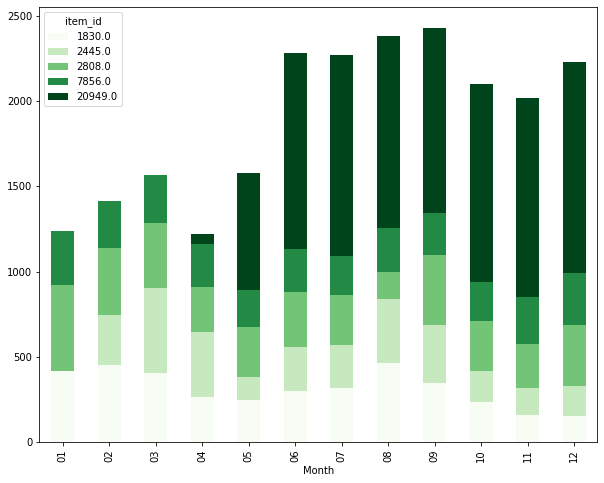

In [19]:
#Monthly sales for top 5 items for the year 2013

seth1 = seth.set_index('Month')
seth2 = seth1.set_index('item_id',append=True)['bymonth'].unstack().plot.bar(stacked=True,figsize = (10,8),colormap='Greens')



#x = Month
#y = bymonth
#stacks = item_id

# Trends in item category

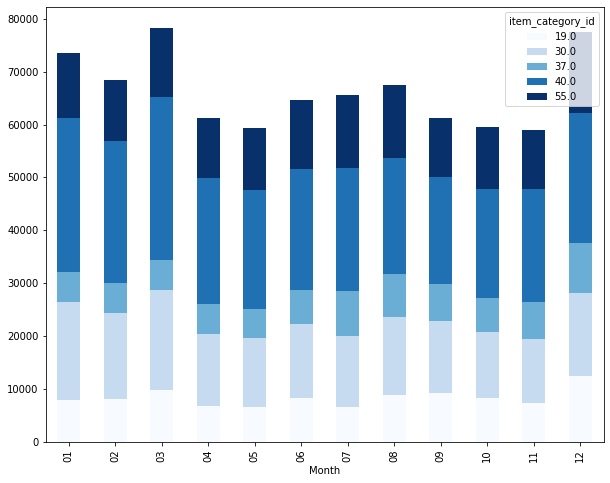

In [20]:
#Yearly trend for categories.
category_2013 = df_2013.groupby('item_category_id').size().reset_index(name = 'CategorySaleByYear2013')
category_2014 = df_2014.groupby('item_category_id').size().reset_index(name = 'CategorySaleByYear2014')
category_2015 = df_2015.groupby('item_category_id').size().reset_index(name = 'CategorySaleByYear2015')


#Finding the top 10 categories per year
topcategory_2013 = category_2013.sort_values(by=['CategorySaleByYear2013'], ascending=False).head(10)
topcategory_2014 = category_2014.sort_values(by=['CategorySaleByYear2014'], ascending=False).head(10)
topcategory_2015 = category_2015.sort_values(by=['CategorySaleByYear2015'], ascending=False).head(10)

topcategory5_2013 = category_2013.sort_values(by=['CategorySaleByYear2013'], ascending=False).head(5)
k1 = df_2013.groupby(['Month','item_category_id']).size().reset_index(name = 'bymonth')

#Month-wise sales for top 5 categories
seth_1 = pd.merge(left=k1,right=topcategory5_2013, left_on='item_category_id', right_on='item_category_id')


demo1 = seth_1.set_index('Month')
demo2 = demo1.set_index('item_category_id',append=True)['bymonth'].unstack().plot.bar(stacked=True,figsize = (10,8),colormap='Blues')


/Users/slavvy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/slavvy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/slavvy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/slavvy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/slavvy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


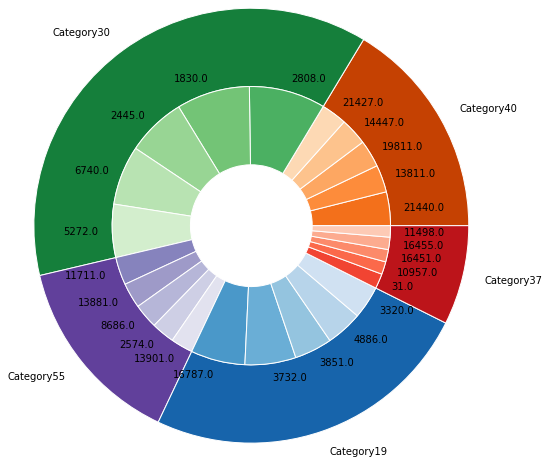

In [21]:
#Finding top 5 items in most popular categories

df_cat19 = df_2013[df_final["item_category_id"] == 19.0]
df_cat30 = df_2013[df_final["item_category_id"] == 30.0]
df_cat37 = df_2013[df_final["item_category_id"] == 37.0]
df_cat40 = df_2013[df_final["item_category_id"] == 40.0]
df_cat55 = df_2013[df_final["item_category_id"] == 55.0]


itemcategory19_2013 = df_cat19.groupby('item_id').size().reset_index(name = 'TopIteminTopCategory19').sort_values(by=['TopIteminTopCategory19'], ascending=False).head(5)
itemcategory30_2013 = df_cat30.groupby('item_id').size().reset_index(name = 'TopIteminTopCategory30').sort_values(by=['TopIteminTopCategory30'], ascending=False).head(5)
itemcategory37_2013 = df_cat37.groupby('item_id').size().reset_index(name = 'TopIteminTopCategory37').sort_values(by=['TopIteminTopCategory37'], ascending=False).head(5)
itemcategory40_2013 = df_cat40.groupby('item_id').size().reset_index(name = 'TopIteminTopCategory40').sort_values(by=['TopIteminTopCategory40'], ascending=False).head(5)
itemcategory55_2013 = df_cat55.groupby('item_id').size().reset_index(name = 'TopIteminTopCategory55').sort_values(by=['TopIteminTopCategory55'], ascending=False).head(5)

fig, ax = plt.subplots()

size = 0.9
#vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
vals = topcategory5_2013['CategorySaleByYear2013'].tolist()
vals40 = itemcategory40_2013['TopIteminTopCategory40'].tolist()
vals30 = itemcategory30_2013['TopIteminTopCategory30'].tolist()
vals55 = itemcategory55_2013['TopIteminTopCategory55'].tolist()
vals19 = itemcategory19_2013['TopIteminTopCategory19'].tolist()
vals37 = itemcategory37_2013['TopIteminTopCategory37'].tolist()
valfin = vals40+vals30+vals55+vals19+vals37
#vals = np.array(vals)
valfin = np.array([vals40,vals30,vals55,vals19,vals37])

cmap1 = plt.cm.Oranges
cmap2 = plt.cm.Greens
cmap3 = plt.cm.Purples
cmap4 = plt.cm.Blues
cmap5 = plt.cm.Reds

l1=itemcategory40_2013['item_id'].tolist()
l2=itemcategory30_2013['item_id'].tolist()
l3=itemcategory55_2013['item_id'].tolist()
l4=itemcategory19_2013['item_id'].tolist()
l5=itemcategory37_2013['item_id'].tolist()
subgroup_names = l1+l2+l3+l4+l5


group_names=['Category40', 'Category30', 'Category55','Category19', 'Category37']

outer_colors = [cmap1(.8), cmap2(.8), cmap3(.8), cmap4(.8), cmap5(.8)]
inner_colors = [*cmap1(np.linspace(.6, .2, 5)),
                *cmap2(np.linspace(.6, .2, 5)),
                *cmap3(np.linspace(.6, .2, 5)),
                *cmap4(np.linspace(.6, .2, 5)),
                *cmap5(np.linspace(.6, .2, 5))]

ax.pie(valfin.sum(axis=1), radius=2.5,colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=group_names)

ax.pie(valfin.flatten(), radius=2.5-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=subgroup_names)

ax.set(aspect="equal")
plt.show()

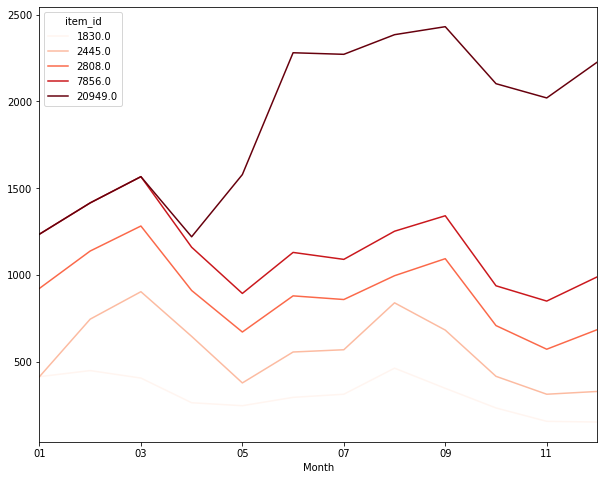

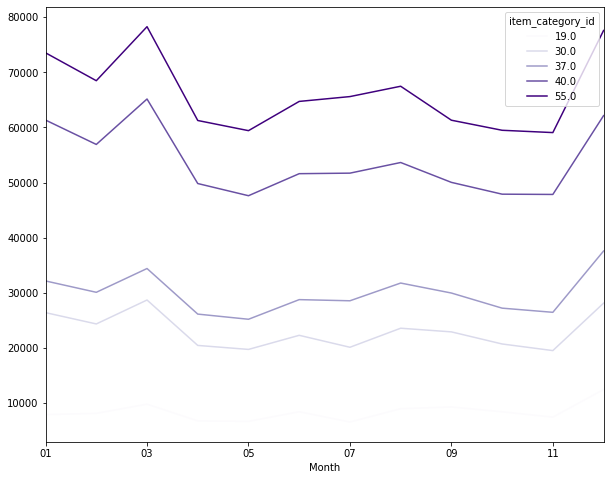

In [22]:
new1 = seth1.set_index('item_id',append=True)['bymonth'].unstack().plot.line(stacked=True,figsize = (10,8),colormap='Reds')
new2 = demo1.set_index('item_category_id',append=True)['bymonth'].unstack().plot.line(stacked=True,figsize = (10,8),colormap='Purples')



In [23]:
#Finding out the shops, items and categories that went out of business

g1=grp_2013['shop_id'].tolist()
g2=grp_2014['shop_id'].tolist()
g3=grp_2015['shop_id'].tolist()
g2014 = list(set(g1) - set(g2))
g2015 = list(set(g2) - set(g3))
print("IDs of the Shops that went out of business in year 2014:",g2014)
print("IDs of the Shops that went out of business in year 2015:",g2015)


g10=category_2013['item_category_id'].tolist()
g20=category_2014['item_category_id'].tolist()
g30=category_2015['item_category_id'].tolist()
gi2014 = list(set(g10) - set(g20))
gi2015 = list(set(g20) - set(g30))
print("IDs of the categories that went out of business in year 2014:",gi2014)
print("IDs of the categories that went out of business in year 2015:",gi2015)

IDs of the Shops that went out of business in year 2014: [0.0, 1.0, 32.0, 8.0, 23.0]
IDs of the Shops that went out of business in year 2015: [13.0]
IDs of the categories that went out of business in year 2014: [0.0, 1.0, 10.0, 48.0, 18.0, 52.0]
IDs of the categories that went out of business in year 2015: [32.0, 66.0, 68.0, 13.0, 51.0, 53.0]


In [24]:
#Finding out the percentage increase or decrease in year-wise sales (By item_id and shop_id)
shop1314 = pd.merge(left=grp_2013,right=grp_2014, left_on='shop_id', right_on='shop_id')
pershop1413 = ((shop1314['ShopSaleByYear2014']-shop1314['ShopSaleByYear2013'])/shop1314['ShopSaleByYear2013'])*100
shop1314['Per1314'] = pershop1413
negincrshop = shop1314.sort_values(by=['Per1314'], ascending=True).head(5) #Top 5 shops with most percentage decrease in sales
posincrshop = shop1314.sort_values(by=['Per1314'], ascending=False).head(5)#Top 5 shops with most percentage increase in sales

item1314 = pd.merge(left=item_2013,right=item_2014, left_on='item_id', right_on='item_id')
per1413 = ((item1314['ItemSaleByYear2014']-item1314['ItemSaleByYear2013'])/item1314['ItemSaleByYear2013'])*100
item1314['Percentage1314'] = per1413
negincr = item1314.sort_values(by=['Percentage1314'], ascending=True).head(5) #Top 5 items with most percentage decrease in sales
posincr = item1314.sort_values(by=['Percentage1314'], ascending=False).head(5) #Top 5 items with most percentage decrease in sales
negincrshop

,shop_id,ShopSaleByYear2013,ShopSaleByYear2014,Per1314
9,13.0,12208,5616,-53.997379
14,18.0,26643,15454,-41.996021
37,50.0,34745,21024,-39.490574
12,16.0,25753,16451,-36.120064
27,37.0,18794,12138,-35.415558


# Data Cleaning

## Shop names processing- Removing unwanted characters from shop names using python regex.

In [25]:
df_shops=pd.read_csv("shops.csv")

In [26]:
df_shops['shop_name'] = df_shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()


In [27]:
df_shops.head(5)

,shop_name,shop_id
0,якутск орджоникидзе фран,0
1,якутск тц центральный фран,1
2,адыгея тц мега,2
3,балашиха трк октябрькиномир,3
4,волжский тц волга молл,4


## Item names processing - Removing unwanted characters from item names and checking and removing duplicacy.

In [28]:
df_items=pd.read_csv("items.csv")

In [29]:
df_sales=pd.read_csv("sales_train.csv")

In [30]:
df_items['item_name'], df_items['item_type'] = df_items['item_name'].str.split('[', 1).str
df_items['item_name'], df_items['item_subtype'] = df_items['item_name'].str.split('(', 1).str


In [31]:
df_items['item_name']=df_items['item_name'].apply(lambda x : x.lower()).str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.strip()
df_items['item_type']=df_items['item_type'].apply(lambda x : str(x).lower()).str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.strip()
df_items['item_subtype']=df_items['item_subtype'].apply(lambda x : str(x).lower()).str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.strip()


In [32]:
df_items.fillna("Others").head(5)

,item_name,item_id,item_category_id,item_type,item_subtype
0,во власти наваждения,0,40,nan,пласт d
1,abbyy finereader 12 professional edition full,1,76,pc цифровая версия,nan
2,в лучах славы,2,40,nan,unv d
3,голубая волна,3,40,nan,univ d
4,коробка,4,40,nan,стекло d


In [33]:
df_sales.loc[df_sales['shop_id'] == 11, 'shop_id'] = 10
df_shops.loc[df_shops['shop_id'] == 11, 'shop_id'] = 10

df_sales.loc[df_sales['shop_id'] == 23, 'shop_id'] = 24
df_shops.loc[df_shops['shop_id'] == 23, 'shop_id'] = 24

df_sales.loc[df_sales['shop_id'] == 0, 'shop_id'] = 57
df_shops.loc[df_shops['shop_id'] == 0, 'shop_id'] = 57

df_sales.loc[df_sales['shop_id'] == 1, 'shop_id'] = 58
df_shops.loc[df_shops['shop_id'] == 1, 'shop_id'] = 58

df_sales.loc[df_sales['shop_id'] == 40, 'shop_id'] = 39
df_shops.loc[df_shops['shop_id'] == 40, 'shop_id'] = 39

df_shops = df_shops.drop_duplicates(subset = 'shop_id')

# Feature Engineering

##  Using Autocorelation function to determine how much the previous values of the features affects the prediction of the current features.

##  ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

In [34]:
def lag_features(dataframe, attribute, target_variable, time_column, aggregation_function = np.sum, fill = 0):
    df_attributes = dataframe.pivot_table(index = attribute,
                                   values = target_variable, 
                                   columns = time_column, 
                                   aggfunc = aggregation_function, 
                                   fill_value = fill,
                                  ).reset_index()
    df_attributes.columns = df_attributes.columns.map(str)
    df_attributes = df_attributes.reset_index(drop = True).rename_axis(None, axis = 1)
    return df_attributes

In [35]:
df_sales = df_sales.merge(df_items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')

In [36]:
time_shift=15

## Autocorrelation between shop_id and item_id.

/Users/slavvy/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:546: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


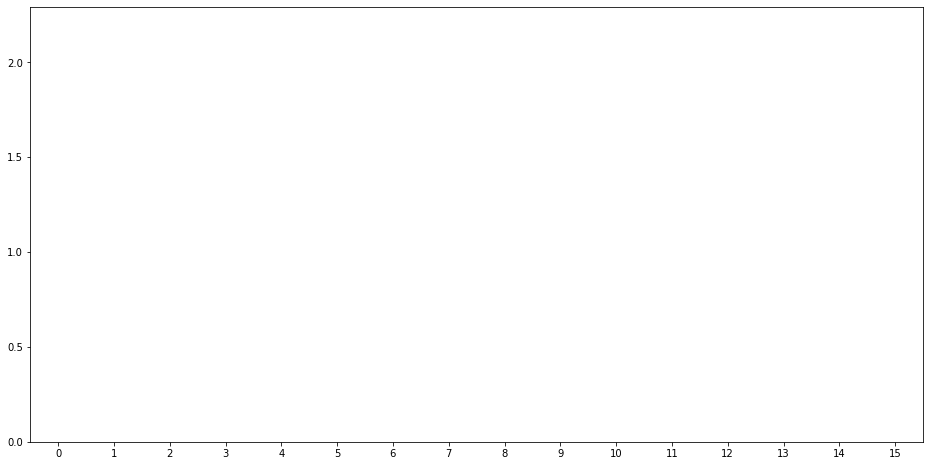

In [37]:
sales_lag_features = lag_features(df_sales, ['shop_id', 'item_id'], 'item_cnt_day', 'date_block_num', aggregation_function = np.sum, fill = 0)



# Finding every item id sold in every month. There are 34 months.

shops_items_sales_sampled = sales_lag_features.sample(1000)


pairs = np.zeros((shops_items_sales_sampled.shape[0], time_shift + 1))
for i, (index, shop_items) in enumerate(shops_items_sales_sampled.iterrows()):
    pair = shop_items.loc['0': ]
    auto_correcction_fn = acf(pair, nlags = time_shift, fft = True)
    pairs[i, :] = auto_correcction_fn


Y = np.mean(pairs, axis = 0)
X=np.arange(time_shift + 1)
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x =X , y = Y)



## Looking at the graph, selecting the lag features which are highly co-related.

In [38]:
pairs_id_lag = [1, 2, 3, 4, 8, 10, 11, 12]

## Autocorelations based on item_id

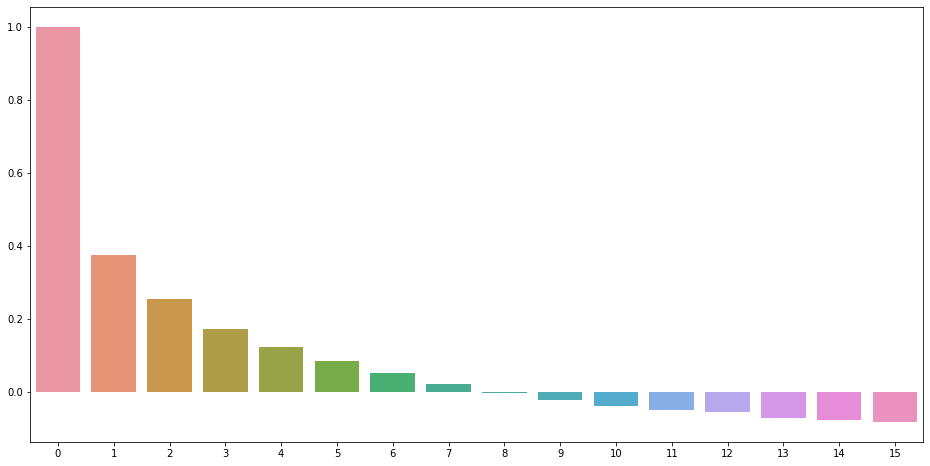

In [39]:
lag_on_item_id = lag_features(df_sales, ['item_id'], 'item_cnt_day', 'date_block_num', aggregation_function = np.sum, fill = 0)


items_lag = np.zeros((lag_on_item_id.shape[0], time_shift + 1))
for i, item_sales in lag_on_item_id.iterrows():
    item_temp = item_sales.loc['0': ]
    if np.sum(item_temp) != 0:
        items_acf_15 = acf(item_temp, nlags = time_shift, fft = True)
        items_lag[i, :] = items_acf_15
        

                
Y = np.mean(items_lag, axis = 0)
X=np.arange(time_shift + 1)
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x =X , y = Y)

## Looking at the graph, selecting the lag features which are highly co-related.

In [40]:
item_id_lag = [1, 2, 3, 4, 5, 10, 11, 12]

# Autocorelation on shop_id 

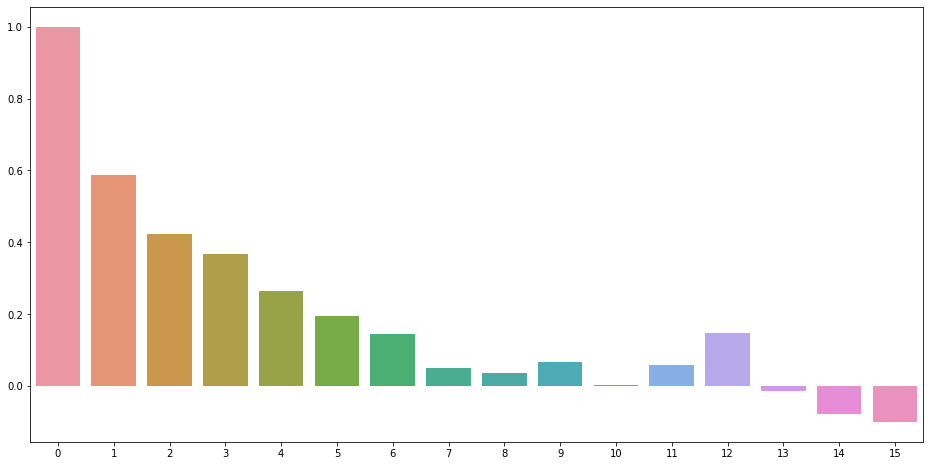

In [41]:
lag_on_shop_id = lag_features(df_sales, ['shop_id'], 'item_cnt_day', 'date_block_num', aggregation_function = np.sum, fill = 0)


shop_lag = np.zeros((lag_on_shop_id.shape[0], time_shift + 1))
for i, shop_sales in lag_on_shop_id.iterrows():
    shop_id_temp = shop_sales.loc['0': ]
    shops_acf_15 = acf(shop_id_temp, nlags = time_shift, fft = True)
    shop_lag[i, :] = shops_acf_15
    
Y = np.mean(shop_lag, axis = 0)
X=np.arange(time_shift + 1)
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x =X , y = Y)

## Looking at the graph, selecting the lag features which are highly co-related.

In [42]:
shop_id_lag = [1, 2, 3, 4, 7, 8, 10, 12]

# Autocorelation on item_category_id

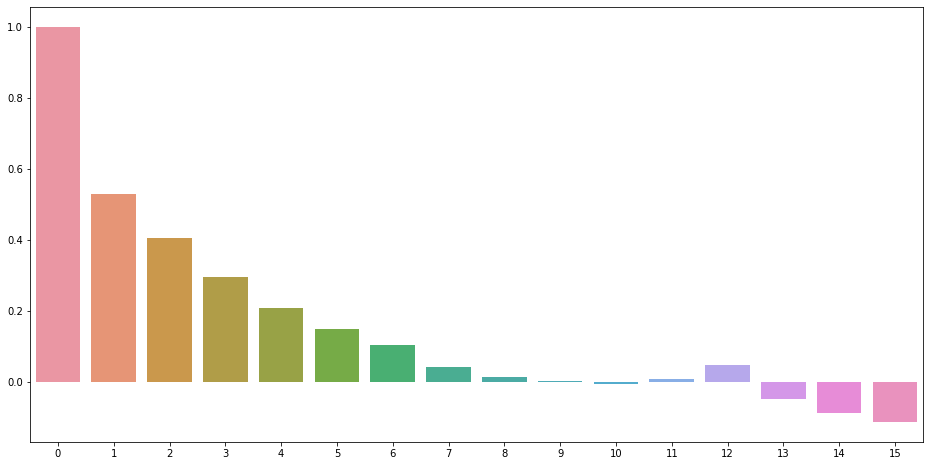

In [43]:
lag_on_item_category_id = lag_features(df_sales, ['item_category_id'], 'item_cnt_day', 'date_block_num', aggregation_function = np.sum, fill = 0)

categories_lag = np.zeros((lag_on_item_category_id.shape[0], time_shift + 1))

for i, category_id in lag_on_item_category_id.iterrows():
    category_id_temp = category_id.loc['0': ]
    category_acf_15 = acf(category_id_temp, nlags = time_shift, fft = True)
    categories_lag[i, :] = category_acf_15
    
Y = np.mean(categories_lag, axis = 0)
X=np.arange(time_shift + 1)
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x = X, y = Y)

## Looking at the graph, selecting the lag features which are highly co-related.

In [44]:
category_id_lag = [1, 2, 3, 4, 5, 6, 12]

# Creating Training Data

In [45]:
df_test = pd.read_csv( 'test.csv')

In [46]:
df_items=pd.read_csv("items.csv")

## Creating a data table by grouping the data according to item_cnt_day.

In [47]:
columns_id = ['shop_id', 'item_id', 'date_block_num'] 

def training_data(dataframe, columns_id = columns_id):
    table = []
    for month in dataframe['date_block_num'].unique():
        shops_id = dataframe[dataframe['date_block_num'] == month]['shop_id'].unique()
        items_id = dataframe[dataframe['date_block_num'] == month]['item_id'].unique()
        table.append(np.array(list(product(*[shops_id, items_id, [month]])), dtype = 'int32'))

    table = pd.DataFrame(np.vstack(table), columns = columns_id, dtype = np.int32)
    temp_table = dataframe.groupby(columns_id, as_index = False).agg({'item_cnt_day':'sum'})
    temp_table.columns = columns_id + ['target']
    all_data_table = pd.merge(table, temp_table, how = 'left', on = columns_id).fillna(0)
    all_data_table.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
    all_data_table.loc[:, 'target'] = all_data_table['target'].clip(0, 20).astype(np.float32)
    
    return all_data_table

table = training_data(df_sales, columns_id)
df_test['date_block_num'] = 34
table = pd.concat([table, df_test[['item_id', 'shop_id', 'date_block_num']]], ignore_index = True, sort = False, keys = columns_id)
table = table.merge(df_items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')



In [48]:
table.head(5)

,shop_id,item_id,date_block_num,target,item_category_id
0,2,19,0,0.0,40
1,2,27,0,1.0,19
2,2,28,0,0.0,30
3,2,29,0,0.0,23
4,2,32,0,0.0,40


## Creating functions to add autocorelation lag features to the training data.

In [49]:
def fast_lag_features_table(dataframe, features_value, time_shift): 
    features_sales = lag_features(df_sales, features_value, 'item_cnt_day', 'date_block_num', aggregation_function = np.sum, fill = 0)
    for month in time_shift:
        max_month_value = dataframe.date_block_num.max()
        columns = [str(x) for x in np.arange(0, max_month_value)]
        table = features_sales.melt( id_vars = features_value, var_name = 'date_block_num' , value_vars= columns, value_name = 'targetvalue_' + '_'.join(features_value) + '_lag_' + str(month))
        table.date_block_num = table.date_block_num.astype(np.int16)
        table.date_block_num = table.date_block_num + month
        dataframe = pd.merge(dataframe, table, on = features_value + ['date_block_num'], how='left')
    return dataframe

def lag_features_table(dataframe, features, time_shift):
    for month_shift in time_shift:
        dataframe_shift = dataframe[columns_id + features].copy()
        dataframe_shift['date_block_num'] = dataframe_shift['date_block_num'] + month_shift
        lag_columns = lambda x: '{}_lag_{}'.format(x, month_shift) if x in features else x
        dataframe_shift = dataframe_shift.rename(columns = lag_columns)
        dataframe = pd.merge(dataframe, dataframe_shift, on = columns_id, how='left')
    return dataframe

In [50]:
table = lag_features_table(table, ['target'], pairs_id_lag)

In [51]:
table.head(1)

,shop_id,item_id,date_block_num,target,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_8,target_lag_10,target_lag_11,target_lag_12
0,2,19,0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
table = fast_lag_features_table(table, ['item_id'], item_id_lag)

In [ ]:
table = fast_lag_features_table(table, ['shop_id'], shop_id_lag)

In [ ]:
table = fast_lag_features_table(table, ['item_category_id'], category_id_lag)

In [ ]:
table.columns.tolist()

In [ ]:
table = table[table['date_block_num'] > 12]
table = table.fillna(0)

In [ ]:
table.head(2)

# Adding date features.

In [ ]:
train_data = df_sales.loc[:, ['date', 'date_block_num']].drop_duplicates()


train_data = train_data.reset_index(drop = True)
test_data = train_data.loc[train_data.loc[:, 'date_block_num'] == 34 - 12]
test_data = test_data.reset_index(drop=True)
test_data.loc[:,'date_block_num'] = 34

train_data['date']=train_data['date'].apply(lambda x: parser.parse(x) +  pd.DateOffset(years = 1))
all_data = pd.concat([train_data, test_data])
all_data['date']=all_data['date'].apply(lambda x :pd.to_datetime(x))

all_data.loc[:, 'dow'] = all_data.loc[:, 'date'].dt.dayofweek
all_data.loc[:, 'year'] = all_data.loc[:, 'date'].dt.year
all_data.loc[:, 'month'] = all_data.loc[:, 'date'].dt.month

all_data = pd.get_dummies(all_data, columns = ['dow'])
week_column = ['dow_' + str(x) for x in range(7)]
date_columns = all_data.groupby(['year', 'month', 'date_block_num'])[week_column].agg('sum').reset_index()
date_columns.loc[:, 'days_of_month'] = date_columns.loc[:, week_column].sum(axis=1)
date_columns.loc[:, 'year'] = date_columns.loc[:, 'year'] - 2013
date_columns = date_columns.loc[:, ['month', 'date_block_num']]


table = table.merge(date_columns, on = 'date_block_num', how = 'left')

In [ ]:
le = preprocessing.LabelEncoder()

## Data columns for the model. 

In [ ]:
table['category_shop_inter'] = table['item_category_id'].astype(str) + '_' + table['shop_id'].astype(str)
table.loc[:, 'category_shop_inter'] = le.fit_transform(table.loc[:, 'category_shop_inter'].values)

In [ ]:
cols_to_drop = ['target', 'date_block_num']
def train_val_test_split(df):
    dates = df['date_block_num']
    last_block = dates.max()
    print('Test `date_block_num` is %d' % last_block)
    print('Validation `date_block_num` is %d' % (last_block - 1))
    print('Train `date_block_num` is < %d' % (last_block - 1))
    print('------------------------------')

    X_train = df.loc[dates < last_block - 1].drop(cols_to_drop, axis = 1)
    X_val = df.loc[dates == last_block - 1].drop(cols_to_drop, axis = 1)
    X_test =  df.loc[dates == last_block].drop(cols_to_drop, axis = 1)

    y_train = df.loc[dates < last_block - 1, 'target'].values
    y_val =  df.loc[dates == last_block - 1, 'target'].values
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    print('------------------------------')
    print('X_val shape: ', X_val.shape)
    print('y_val shape: ', y_val.shape)
    print('------------------------------')
    print('X_test shape: ', X_test.shape)
    print('------------------------------')
    return (X_train, y_train, X_val, y_val, X_test)

def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

def create_lgbm_model(X_train, y_train, X_val, y_val, params, cat_feats):
    n_estimators = 8000
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_val, y_val)
    watchlist = [d_train, d_valid]
    evals_result = {}
    model = lgb.train(params, 
                      d_train, 
                      n_estimators,
                      valid_sets = watchlist, 
                      evals_result = evals_result, 
                      early_stopping_rounds = 50,
                      verbose_eval = 0,
                      categorical_feature = cat_feats,
                    )
    lgb.plot_metric(evals_result)
    return model

def evaluate_model(model, X_train, y_train, X_val, y_val): 
    y_hat = model.predict(X_train)
    print('Training error;', rmse(y_train, y_hat))
    y_val_hat = model.predict(X_val)
    print('Validation error:', rmse(y_val, y_val_hat))

In [ ]:
categorical_features = ['shop_id', 'item_category_id', 'month', 'category_shop_inter']
for col in categorical_features:
    table.loc[:, col] = table[col].astype('category')

In [ ]:
X_train, y_train, X_val, y_val, X_test = train_val_test_split(table)

In [ ]:
#X_train.to_csv("X_train.csv")

In [ ]:
import lightgbm as lgb
import time

In [ ]:
start = time.time()
params = {
  'metric': 'rmse',
  'objective': 'mse',
  'verbose': 0, 
  'learning_rate': 0.1,
  'num_leaves': 31,
  'min_data_in_leaf': 20 ,
  'max_depth': -1,
  'save_binary': True,
  'bagging_fraction': 0.8,
  'bagging_freq': 1,
  'bagging_seed': 2**7, 
  'feature_fraction': 0.8,
}
lgbm_model = create_lgbm_model(X_train, y_train, X_val, y_val, params, categorical_features)
print('It took: ', round(time.time() - start), 'seconds')

In [ ]:
start = time.time()
evaluate_model(lgbm_model, X_train, y_train, X_val, y_val)
print('it tooks: ', round(time.time() - start), 'seconds')

In [ ]:
ax = lgb.plot_importance(lgbm_model, max_num_features = 40, figsize = (8, 10))
plt.show()

In [ ]:
y_test_pred = lgbm_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.ID, 
    "item_cnt_month": y_test_pred
})
submission.to_csv('lgbm_submission.csv', index = False)

In [ ]:
export PATH=/usr/local/bin/anaconda3/bin${PATH:+:${PATH}}
PYTHONPATH=$PYTHONPATH:/usr/local/bin/anaconda3/lib/python3.6/site-packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import gc
from itertools import product
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import time



In [ ]:
!pip install numpy